In [1]:
import pandas as pd
import sys
sys.path.append("../lib")
import seaborn as sns
import matplotlib.pyplot as plt
from utils import iterate_over
from utils import load_config_and_check
from inspector import Inspector
from tqdm import tqdm
import sqlite3 as sl
import os

In [2]:
%load_ext autoreload
%autoreload 2

## Utility functions

In [3]:
import pathlib
from os.path import join
import shutil


def retrieve_relevant_file_paths(
        experiment_folder: str, 
        program_id: str,
        root_folder: str = "../data"):
    """Create the file paths."""
    main_path = os.path.join(root_folder, experiment_folder, "programs")
    path_dict = {
        "source": join(main_path, "source", f"{program_id}.py"),
        "followup": join(main_path, "followup", f"{program_id}.py"),
        "metadata": join(main_path, "metadata", f"{program_id}.json"),
        "metadata_exec": join(main_path, "metadata_exec", f"{program_id}.json")
    }
    return path_dict
    
def read_program(path: str):
    print(open(path, 'r').read())
    
def create_folder_in_interesting_cases(
        experiment_folder: str, 
        program_id: str,
        root_folder: str = "../intersting_cases/metamorphic_testing"):
    """Create destination folder for the relevant files."""
    number = "".join([c for c in experiment_folder if c.isdigit()])
    new_folder_name = f"{number}_{program_id[:6]}"
    new_folder_path = os.path.join(root_folder, new_folder_name)
    pathlib.Path(new_folder_path).mkdir(parents=True, exist_ok=True)
    return new_folder_path


def copy_bug(
        experiment_folder: str, 
        program_id: str, 
        root_data_folder: str = "../data",
        root_bug_folder: str = "../intersting_cases/metamorphic_testing"):
    """Copy all the files of the interesting bug."""
    dest_folder = create_folder_in_interesting_cases(
        experiment_folder=experiment_folder,
        program_id=program_id,
        root_folder=root_bug_folder
    )
    
    original_file_paths = retrieve_relevant_file_paths(
        experiment_folder=experiment_folder,
        program_id=program_id,
        root_folder=root_data_folder    
    )
    
    for k, original_file_path in original_file_paths.items():
        basename = os.path.basename(original_file_path)
        dest_file_path = join(dest_folder, f"{k}_{basename}")
        print(f"Copying... from {original_file_path} to {dest_file_path}")
        shutil.copy(original_file_path, dest_file_path)

## SQL Database Scan

In [34]:
import pandas as pd

EXP_FOLDER = "qmt_v07" 
sql_path = os.path.join("..", "data", EXP_FOLDER, "qfl.db")
con = sl.connect(sql_path)
df = pd.read_sql("""SELECT * from QFLDATA""", con)

In [35]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 64204 entries, 0 to 64203
Data columns (total 39 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   index                            64204 non-null  int64  
 1   program_id                       64204 non-null  object 
 2   time_exec                        64204 non-null  float64
 3   source.program_id                64204 non-null  object 
 4   source.selected_gate_set         64204 non-null  object 
 5   source.selected_optimization     64204 non-null  object 
 6   source.shots                     64204 non-null  int64  
 7   source.n_qubits                  64204 non-null  int64  
 8   source.n_ops                     64204 non-null  int64  
 9   source.opt_level                 64204 non-null  int64  
 10  source.target_gates              0 non-null      object 
 11  source.py_file_path              64204 non-null  object 
 12  source.time_genera

In [9]:
from collections import Counter
c = Counter(df["exceptions.followup"])
c.most_common(30)

[(None, 23118),
 ("'qargs not in this circuit'", 20223),
 ('"Cannot unroll the circuit to the given basis, [\'cx\', \'h\', \'s\', \'t\']. Instruction id not found in equivalence library and no rule found to expand."',
  8827),
 ('"Cannot unroll the circuit to the given basis, [\'rx\', \'ry\', \'rz\', \'p\', \'cx\']. Instruction id not found in equivalence library and no rule found to expand."',
  6181),
 ('"Cannot unroll the circuit to the given basis, [\'ccx\', \'h\']. Instruction id not found in equivalence library and no rule found to expand."',
  3721),
 ('"Unable to map source basis {(\'cu\', 2), (\'x\', 1)} to target basis {\'barrier\', \'measure\', \'delay\', \'h\', \'reset\', \'snapshot\', \'ccx\'} over library <qiskit.circuit.equivalence.EquivalenceLibrary object at 0x7f69303eab20>."',
  98),
 ('"Unable to map source basis {(\'cu\', 2)} to target basis {\'t\', \'measure\', \'s\', \'barrier\', \'delay\', \'h\', \'cx\', \'reset\', \'snapshot\'} over library <qiskit.circuit.equiv

In [39]:
df_specific_class = df[df["exceptions.followup"] == "'qargs not in this circuit'"]
print(df_specific_class.shape)
PROGRAM_ID = df_specific_class.iloc[0]["program_id"]
PROGRAM_ID

(20236, 39)


'702666942a78493cb86c73e446e32ac2'

### Get most severe P-value cases

In [45]:
possible_exception = list(df["exceptions.followup"].unique())
for i, ex in enumerate(possible_exception):
    print(f"{i}) {type(ex)} {ex}")

0) <class 'str'> 'qargs not in this circuit'
1) <class 'NoneType'> None
2) <class 'str'> "Cannot unroll the circuit to the given basis, ['rx', 'ry', 'rz', 'p', 'cx']. Instruction id not found in equivalence library and no rule found to expand."
3) <class 'str'> "Cannot unroll the circuit to the given basis, ['cx', 'h', 's', 't']. Instruction id not found in equivalence library and no rule found to expand."
4) <class 'str'> "Cannot unroll the circuit to the given basis, ['ccx', 'h']. Instruction id not found in equivalence library and no rule found to expand."
5) <class 'str'> "Unable to map source basis {('cu', 2), ('rz', 1), ('h', 1), ('y', 1)} to target basis {'t', 'measure', 's', 'barrier', 'delay', 'h', 'cx', 'reset', 'snapshot'} over library <qiskit.circuit.equivalence.EquivalenceLibrary object at 0x7f69303ebcd0>."
6) <class 'str'> "Unable to map source basis {('cu', 2), ('u1', 1), ('x', 1), ('crx', 2), ('ry', 1), ('y', 1), ('h', 1)} to target basis {'t', 'measure', 's', 'barrier'

In [90]:
df_no_exception = df[df["exceptions.followup"].isnull()]
# remove problems with swap gate, since they might be due to a mis-use of the API
df_no_exception = df_no_exception[~df_no_exception["source.selected_gate_set"].str.contains("SXGate")]
df_no_exception.sort_values(by="divergence.ks.p-value", inplace=True)
df_no_exception.head()

,index,program_id,time_exec,source.program_id,source.selected_gate_set,source.selected_optimization,source.shots,source.n_qubits,source.n_ops,source.opt_level,...,followup.id_classical_reg,followup.gate_set,followup.metamorphic_strategies,followup.time_metamorph,followup.metamorphic_times,divergence.ks.statistic,divergence.ks.p-value,divergence.ks.time,exceptions.source,exceptions.followup


In [87]:
df_with_swap = df_no_exception = df[df["source.selected_gate_set"].str.contains("SwapGate")]
df_with_swap.head()

,index,program_id,time_exec,source.program_id,source.selected_gate_set,source.selected_optimization,source.shots,source.n_qubits,source.n_ops,source.opt_level,...,followup.id_classical_reg,followup.gate_set,followup.metamorphic_strategies,followup.time_metamorph,followup.metamorphic_times,divergence.ks.statistic,divergence.ks.p-value,divergence.ks.time,exceptions.source,exceptions.followup
0,0,702666942a78493cb86c73e446e32ac2,0.405335,702666942a78493cb86c73e446e32ac2,"['DCXGate', 'CU3Gate', 'SdgGate', 'U1Gate', 'C...",[],489,3,0,3,...,cr,"[{'name': 'DCXGate', 'n_bits': 2, 'n_params': ...",['change_coupling_map'],0.019991,[0.008272771025076509],1.000000,0.004082,0.011086,None,'qargs not in this circuit'
1,0,d16a9864a4b2409fb2bc35f7aeb803be,0.944097,d16a9864a4b2409fb2bc35f7aeb803be,"['DCXGate', 'CU3Gate', 'SdgGate', 'U1Gate', 'C...",[],3919,9,22,3,...,cr,"[{'name': 'DCXGate', 'n_bits': 2, 'n_params': ...","['inject_circuits_and_inverse', 'change_qubit_...",0.054740,"[0.0045765668619424105, 0.014594408916309476, ...",1.000000,0.000510,0.027485,None,'qargs not in this circuit'
2,0,49ef7ae2154f40ea813c51d18c22b748,0.711311,49ef7ae2154f40ea813c51d18c22b748,"['DCXGate', 'CU3Gate', 'SdgGate', 'U1Gate', 'C...",[],2771,8,19,3,...,cr,"[{'name': 'DCXGate', 'n_bits': 2, 'n_params': ...","['change_backend', 'change_coupling_map']",0.032950,"[0.0056653739884495735, 0.00462045194581151]",1.000000,0.000722,0.019987,None,'qargs not in this circuit'
3,0,4dd1f272ac834f9683a98dd9ca0daa2e,0.846428,4dd1f272ac834f9683a98dd9ca0daa2e,"['DCXGate', 'CU3Gate', 'SdgGate', 'U1Gate', 'C...",[],5542,10,25,3,...,cr,"[{'name': 'DCXGate', 'n_bits': 2, 'n_params': ...","['change_opt_level', 'change_qubit_order']",0.040833,"[0.007170661119744182, 0.008883927948772907]",0.006857,0.999466,0.010125,None,None
4,0,1c5a1506bf6d4f4fbd6ca8f48c49903c,0.508497,1c5a1506bf6d4f4fbd6ca8f48c49903c,"['DCXGate', 'CU3Gate', 'SdgGate', 'U1Gate', 'C...",[],692,4,12,3,...,cr,"[{'name': 'DCXGate', 'n_bits': 2, 'n_params': ...","['inject_circuits_and_inverse', 'change_opt_le...",0.038247,"[0.003274753922596574, 0.0067341020330786705, ...",1.000000,0.002886,0.005185,None,'qargs not in this circuit'


In [94]:
df_single = df[df["program_id"] == "af46c02c1e76475f86caebb03b793f32"]
list(df_single["source.selected_gate_set"])

["['DCXGate', 'CU3Gate', 'SdgGate', 'U1Gate', 'CCXGate', 'RYGate', 'CSXGate', 'RYYGate', 'XGate', 'CHGate', 'SwapGate', 'CUGate', 'RZGate', 'IGate', 'ECRGate', 'SXdgGate', 'YGate', 'CRXGate', 'ZGate', 'HGate', 'TdgGate', 'RCCXGate']"]

### Inspect example of programs

In [51]:
BUG_PATHS = retrieve_relevant_file_paths(
    experiment_folder=EXP_FOLDER,
    program_id=PROGRAM_ID
)
BUG_PATHS

{'source': '../data/qmt_v07/programs/source/af46c02c1e76475f86caebb03b793f32.py',
 'followup': '../data/qmt_v07/programs/followup/af46c02c1e76475f86caebb03b793f32.py',
 'metadata': '../data/qmt_v07/programs/metadata/af46c02c1e76475f86caebb03b793f32.json',
 'metadata_exec': '../data/qmt_v07/programs/metadata_exec/af46c02c1e76475f86caebb03b793f32.json'}

In [52]:
print('SOURCE')
read_program(path=BUG_PATHS['source'])

SOURCE

# SECTION
# NAME: PROLOGUE

import qiskit
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister
from qiskit.circuit.library.standard_gates import *

# SECTION
# NAME: CIRCUIT

qr = QuantumRegister(10, name='qr')
cr = ClassicalRegister(10, name='cr')
qc = QuantumCircuit(qr, cr, name='qc')
qc.append(CUGate(1.791678723309873,3.4268190926659594,2.0348474274027337,2.3260376274746286), qargs=[qr[0], qr[5]], cargs=[])
qc.append(YGate(), qargs=[qr[8]], cargs=[])
qc.append(RZGate(5.414425485082705), qargs=[qr[1]], cargs=[])
qc.append(HGate(), qargs=[qr[2]], cargs=[])
qc.append(CSXGate(), qargs=[qr[8], qr[0]], cargs=[])
qc.append(IGate(), qargs=[qr[2]], cargs=[])
qc.append(SwapGate(), qargs=[qr[6], qr[8]], cargs=[])

# SECTION
# NAME: OPTIMIZATION_PASSES

from qiskit.transpiler import PassManager
from qiskit.transpiler.passes import *
passmanager = PassManager()
qc = passmanager.run(qc)

# SECTION
# NAME: OPTIMIZATION_LEVEL

from qiskit import transpile
qc = transpile(qc,

In [53]:
print('FOLLOWUP')
read_program(path=BUG_PATHS['followup'])

FOLLOWUP
# SECTION
# NAME: PROLOGUE

import qiskit
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister
from qiskit.circuit.library.standard_gates import *
# SECTION
# NAME: CIRCUIT

qr = QuantumRegister(10, name='qr')
cr = ClassicalRegister(10, name='cr')
qc = QuantumCircuit(qr, cr, name='qc')
qc.append(CUGate(1.791678723309873, 3.4268190926659594, 2.0348474274027337, 2.3260376274746286), qargs=[qr[0], qr[5]], cargs=[])
qc.append(YGate(), qargs=[qr[8]], cargs=[])
qc.append(RZGate(5.414425485082705), qargs=[qr[1]], cargs=[])
qc.append(HGate(), qargs=[qr[2]], cargs=[])
qc.append(CSXGate(), qargs=[qr[8], qr[0]], cargs=[])
qc.append(IGate(), qargs=[qr[2]], cargs=[])
qc.append(SwapGate(), qargs=[qr[6], qr[8]], cargs=[])
# SECTION
# NAME: OPTIMIZATION_PASSES

from qiskit.transpiler import PassManager
from qiskit.transpiler.passes import *
passmanager = PassManager()
qc = passmanager.run(qc)
# SECTION
# NAME: OPTIMIZATION_LEVEL
from qiskit import transpile
qc = transpile(qc,

In [62]:
#SOURCE

# SECTION
# NAME: PROLOGUE

import qiskit
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister
from qiskit.circuit.library.standard_gates import *

# SECTION
# NAME: CIRCUIT

qr = QuantumRegister(10, name='qr')
cr = ClassicalRegister(10, name='cr')
qc = QuantumCircuit(qr, cr, name='qc')
qc.append(CUGate(1.791678723309873,3.4268190926659594,2.0348474274027337,2.3260376274746286), qargs=[qr[0], qr[5]], cargs=[])
qc.append(YGate(), qargs=[qr[8]], cargs=[])
qc.append(RZGate(5.414425485082705), qargs=[qr[1]], cargs=[])
qc.append(HGate(), qargs=[qr[2]], cargs=[])
qc.append(CSXGate(), qargs=[qr[8], qr[0]], cargs=[])
qc.append(IGate(), qargs=[qr[2]], cargs=[])
qc.append(SwapGate(), qargs=[qr[6], qr[8]], cargs=[])
qc.measure(qr, cr)

# SECTION
# NAME: OPTIMIZATION_PASSES

from qiskit.transpiler import PassManager
from qiskit.transpiler.passes import *
passmanager = PassManager()
qc = passmanager.run(qc)

# SECTION
# NAME: OPTIMIZATION_LEVEL

from qiskit import transpile
qc = transpile(qc, basis_gates=None, optimization_level=3, coupling_map=None)

# SECTION
# NAME: MEASUREMENT

qc.draw(fold=-1)

┌────┐   ┌─┐      
 qr_0: ─────────────────────■──────────────────────────────┤ Sx ├───┤M├──────
                            │                ┌─┐           └─┬──┘   └╥┘      
 qr_1: ─────────────────────┼────────────────┤M├─────────────┼───────╫───────
       ┌───┐                │                └╥┘┌───┐        │       ║ ┌─┐   
 qr_2: ┤ H ├────────────────┼─────────────────╫─┤ I ├────────┼───────╫─┤M├───
       └┬─┬┘                │                 ║ └───┘        │       ║ └╥┘   
 qr_3: ─┤M├─────────────────┼─────────────────╫──────────────┼───────╫──╫────
        └╥┘                 │                 ║  ┌─┐         │       ║  ║    
 qr_4: ──╫──────────────────┼─────────────────╫──┤M├─────────┼───────╫──╫────
         ║  ┌───────────────┴───────────────┐ ║  └╥┘         │   ┌─┐ ║  ║    
 qr_5: ──╫──┤ U(1.7917,3.4268,2.0348,2.326) ├─╫───╫──────────┼───┤M├─╫──╫────
         ║  └───────────────────────────────┘ ║   ║     ┌─┐  │   └╥┘ ║  ║    
 qr_6: ──╫────────────────────────────────────╫───╫─────┤M├──┼────╫──╫──╫────
         ║                                    ║   ║  ┌─┐└╥┘  │    ║  ║  ║    
 qr_7: ──╫────────────────────────────────────╫───╫──┤M├─╫───┼────╫──╫──╫────
         ║                ┌───┐               ║   ║  └╥┘ ║   │    ║  ║  ║ ┌─┐
 qr_8: ──╫────────────────┤ Y ├───────────────╫───╫───╫──╫───■────╫──╫──╫─┤M├
         ║                └┬─┬┘               ║   ║   ║  ║        ║  ║  ║ └╥┘
 qr_9: ──╫─────────────────┤M├────────────────╫───╫───╫──╫────────╫──╫──╫──╫─
         ║                 └╥┘                ║   ║   ║  ║        ║  ║  ║  ║ 
cr: 10/══╩══════════════════╩═════════════════╩═══╩═══╩══╩════════╩══╩══╩══╩═
         3                  9                 1   4   7  8        5  0  2  6

In [63]:
#FOLLOWUP
# SECTION
# NAME: PROLOGUE

import qiskit
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister
from qiskit.circuit.library.standard_gates import *
# SECTION
# NAME: CIRCUIT

qr = QuantumRegister(10, name='qr')
cr = ClassicalRegister(10, name='cr')
qc = QuantumCircuit(qr, cr, name='qc')
qc.append(CUGate(1.791678723309873, 3.4268190926659594, 2.0348474274027337, 2.3260376274746286), qargs=[qr[0], qr[5]], cargs=[])
qc.append(YGate(), qargs=[qr[8]], cargs=[])
qc.append(RZGate(5.414425485082705), qargs=[qr[1]], cargs=[])
qc.append(HGate(), qargs=[qr[2]], cargs=[])
qc.append(CSXGate(), qargs=[qr[8], qr[0]], cargs=[])
qc.append(IGate(), qargs=[qr[2]], cargs=[])
qc.append(SwapGate(), qargs=[qr[6], qr[8]], cargs=[])
qc.measure(qr, cr)
# SECTION
# NAME: OPTIMIZATION_PASSES

from qiskit.transpiler import PassManager
from qiskit.transpiler.passes import *
passmanager = PassManager()
qc = passmanager.run(qc)
# SECTION
# NAME: OPTIMIZATION_LEVEL
from qiskit import transpile
qc = transpile(qc, basis_gates=None, optimization_level=2, coupling_map=None)
# SECTION
# NAME: MEASUREMENT

qc.draw(fold=-1)

┌────┐         ┌─┐         
 qr_0: ──────────────────────────────■────────────────────────┤ Sx ├─────────┤M├─────────
       ┌────────────┐                │                        └─┬──┘┌─┐      └╥┘         
 qr_1: ┤ Rz(5.4144) ├────────────────┼──────────────────────────┼───┤M├───────╫──────────
       └───┬───┬────┘                │                ┌───┐     │   └╥┘       ║ ┌─┐      
 qr_2: ────┤ H ├─────────────────────┼────────────────┤ I ├─────┼────╫────────╫─┤M├──────
           └┬─┬┘                     │                └───┘     │    ║        ║ └╥┘      
 qr_3: ─────┤M├──────────────────────┼──────────────────────────┼────╫────────╫──╫───────
            └╥┘                      │                 ┌─┐      │    ║        ║  ║       
 qr_4: ──────╫───────────────────────┼─────────────────┤M├──────┼────╫────────╫──╫───────
             ║       ┌───────────────┴───────────────┐ └╥┘      │    ║ ┌─┐    ║  ║       
 qr_5: ──────╫───────┤ U(1.7917,3.4268,2.0348,2.326) ├──╫───────┼────╫─┤M├────╫──╫───────
             ║       └───────────────────────────────┘  ║       │    ║ └╥┘    ║  ║ ┌─┐   
 qr_6: ──────╫──────────────────────────────────────────╫───────┼────╫──╫──X──╫──╫─┤M├───
             ║                                          ║  ┌─┐  │    ║  ║  │  ║  ║ └╥┘   
 qr_7: ──────╫──────────────────────────────────────────╫──┤M├──┼────╫──╫──┼──╫──╫──╫────
             ║                     ┌───┐                ║  └╥┘  │    ║  ║  │  ║  ║  ║ ┌─┐
 qr_8: ──────╫─────────────────────┤ Y ├────────────────╫───╫───■────╫──╫──X──╫──╫──╫─┤M├
             ║                     └┬─┬┘                ║   ║        ║  ║     ║  ║  ║ └╥┘
 qr_9: ──────╫──────────────────────┤M├─────────────────╫───╫────────╫──╫─────╫──╫──╫──╫─
             ║                      └╥┘                 ║   ║        ║  ║     ║  ║  ║  ║ 
cr: 10/══════╩═══════════════════════╩══════════════════╩═══╩════════╩══╩═════╩══╩══╩══╩═
             3                       9                  4   7        1  5     0  2  6  8

## LOG SCAN: check the log for keywords

In [10]:
EXP_FOLDER = "qmt_v07" 
log_path = os.path.join("..", "data", EXP_FOLDER, "log_fuzzy.txt")
log_content = open(log_path, 'r').read()
log_lines = log_content.split("\n")

In [11]:
len(log_lines)

1411086

In [28]:
from typing import List
from numba import njit

def scan_log_for(log_lines: List[str], 
                 target_string: str,
                 exclude_string: str = None, 
                 neighborhood: int = 3):
    """Returns all the lines with the target string."""
    relevant_lines: List[List[str]] = []
    i: int = 0
    for line in log_lines:
        if target_string in line:
            if exclude_string is not None and exclude_string in line: 
                continue
            relevant_lines.append(log_lines[i-neighborhood : i+neighborhood])
        i = i + 1
    return relevant_lines
    

In [29]:
#import numba as nb
#numba_log_lines = nb.typed.List(log_lines)

### Clear crashes

In [30]:
relevant_lines = scan_log_for(
    log_lines=log_lines, 
    target_string="'followup':",
    exclude_string="'followup': None"
)
relevant_lines

[['Applying transformation: change_coupling_map',
  'Follow: coupling map changed:None -> [[0, 1], [0, 3], [1, 0], [1, 2], [2, 1], [3, 0]]',
  'Executing: 702666942a78493cb86c73e446e32ac2 (2022-02-25-18:15:44)',
  'Crash found. Exception:  {\'source\': None, \'followup\': "\'qargs not in this circuit\'"}',
  '1 new divergent programs found.',
  '   index                        program_id  time_exec  ... divergence.ks.time exceptions.source          exceptions.followup'],
 ['Applying transformation: change_coupling_map',
  'Follow: coupling map changed:None -> [[0, 1], [0, 2], [1, 0], [2, 0], [2, 5], [2, 6], [2, 7], [2, 8], [3, 6], [4, 6], [5, 2], [6, 2], [6, 3], [6, 4], [7, 2], [8, 2]]',
  'Executing: d16a9864a4b2409fb2bc35f7aeb803be (2022-02-25-18:15:45)',
  'Crash found. Exception:  {\'source\': None, \'followup\': "\'qargs not in this circuit\'"}',
  '1 new divergent programs found.',
  '   index                        program_id  time_exec  ... divergence.ks.time exceptions.source 

### Divergent Cases

In [31]:
relevant_lines = scan_log_for(log_lines=log_lines, target_string="divergent")

In [33]:
print(len(relevant_lines))
relevant_lines

41741


[['Follow: coupling map changed:None -> [[0, 1], [0, 3], [1, 0], [1, 2], [2, 1], [3, 0]]',
  'Executing: 702666942a78493cb86c73e446e32ac2 (2022-02-25-18:15:44)',
  'Crash found. Exception:  {\'source\': None, \'followup\': "\'qargs not in this circuit\'"}',
  '1 new divergent programs found.',
  '   index                        program_id  time_exec  ... divergence.ks.time exceptions.source          exceptions.followup',
  "0      0  702666942a78493cb86c73e446e32ac2   0.405335  ...           0.011086              None  'qargs not in this circuit'"],
 ['Follow: coupling map changed:None -> [[0, 1], [0, 2], [1, 0], [2, 0], [2, 5], [2, 6], [2, 7], [2, 8], [3, 6], [4, 6], [5, 2], [6, 2], [6, 3], [6, 4], [7, 2], [8, 2]]',
  'Executing: d16a9864a4b2409fb2bc35f7aeb803be (2022-02-25-18:15:45)',
  'Crash found. Exception:  {\'source\': None, \'followup\': "\'qargs not in this circuit\'"}',
  '1 new divergent programs found.',
  '   index                        program_id  time_exec  ... diverge

In [10]:
# qmt_v04 22 Feb 2022 - 21.00
# 55385058d848436999d31be9c0d45387  4.561414e-07 
# 700ae3ec79e747d48df6d0c3a295bf7f  4.640498e-07
# 9fd329b62a4d4f76a82bef40a43e3c41  9.427501e-07
# bf9d01db885a4c65a8e28e5ff4e06ef9  7.748918e-07 
# 9044f1ee448d4f79999afe768e5e7b3f  2.906607e-07
# 4dbd77852fc84c41a515e84a7b0ef8b5  7.049732e-09
# 8ae5d6abf9ee4bb8813aab605e5e036d  8.337349e-07
# 83936da814534c7ba7275030fa389b45  6.009361e-07

In [9]:
log_lines[:20]

['Starting loop... [no timer]',
 'New program couple... [timer: 120 sec]',
 'Executing: f53cc98f2591430887207c1d0bad0ce3',
 "Crash found. Exception:  {'source': None, 'followup': None}",
 '(i: 1) current p-value: 0.21832550182998656 vs threshold: 0.05',
 'i*: 0',
 'New program couple... [timer: 120 sec]',
 'Executing: f3773a633a664e02810b372d000f0937',
 "Crash found. Exception:  {'source': None, 'followup': None}",
 '(i: 1) current p-value: 0.06382648295290216 vs threshold: 0.025',
 'i*: 0',
 'New program couple... [timer: 120 sec]',
 'Executing: 87bd57221135466aa5fbe6d64823225c',
 "Crash found. Exception:  {'source': None, 'followup': None}",
 '(i: 1) current p-value: 0.02698591735714151 vs threshold: 0.016666666666666666',
 'i*: 0',
 'New program couple... [timer: 120 sec]',
 'Executing: 2c78a8718f664594975911795686b986',
 "Crash found. Exception:  {'source': None, 'followup': None}",
 '(i: 1) current p-value: 0.02698591735714151 vs threshold: 0.0125']

## Copy in Intesting Cases

In [4]:
# copy a given program in the interesting cases folder
EXP_FOLDER = "qmt_v05" 
PROGRAM_ID = "824c28fef26e41ab8ca656c1068c5799"

In [67]:
BUG_PATHS = retrieve_relevant_file_paths(
    experiment_folder=EXP_FOLDER,
    program_id=PROGRAM_ID
)
BUG_PATHS

{'source': '../data/qmt_v06/programs/source/948f90de9947418289b220bd2e61caa3.py',
 'followup': '../data/qmt_v06/programs/followup/948f90de9947418289b220bd2e61caa3.py',
 'metadata': '../data/qmt_v06/programs/metadata/948f90de9947418289b220bd2e61caa3.json',
 'metadata_exec': '../data/qmt_v06/programs/metadata_exec/948f90de9947418289b220bd2e61caa3.json'}

In [5]:
create_folder_in_interesting_cases(
    experiment_folder=EXP_FOLDER,
    program_id=PROGRAM_ID
)

'../intersting_cases/metamorphic_testing/05_824c28'

In [6]:
copy_bug(
    experiment_folder=EXP_FOLDER,
    program_id=PROGRAM_ID
)

Copying... from ../data/qmt_v05/programs/source/824c28fef26e41ab8ca656c1068c5799.py to ../intersting_cases/metamorphic_testing/05_824c28/source_824c28fef26e41ab8ca656c1068c5799.py
Copying... from ../data/qmt_v05/programs/followup/824c28fef26e41ab8ca656c1068c5799.py to ../intersting_cases/metamorphic_testing/05_824c28/followup_824c28fef26e41ab8ca656c1068c5799.py
Copying... from ../data/qmt_v05/programs/metadata/824c28fef26e41ab8ca656c1068c5799.json to ../intersting_cases/metamorphic_testing/05_824c28/metadata_824c28fef26e41ab8ca656c1068c5799.json
Copying... from ../data/qmt_v05/programs/metadata_exec/824c28fef26e41ab8ca656c1068c5799.json to ../intersting_cases/metamorphic_testing/05_824c28/metadata_exec_824c28fef26e41ab8ca656c1068c5799.json


## Rerun programs

In [54]:
from qmt import execute_programs
from detectors import KS_Detector
from inspector import OneNightStandInspector

In [55]:
RES = execute_programs(
    metadata_source = {"py_file_path": BUG_PATHS["source"]},
    metadata_followup = {"py_file_path": BUG_PATHS["followup"]}
)
RES

Crash found. Exception:  {'source': None, 'followup': None}


{'res_A': {'0100000101': 1375,
  '0100000100': 1377,
  '0100000001': 1403,
  '0100000000': 1387},
 'platform_A': 'source',
 'res_B': {'0001000001': 1395,
  '0001000000': 1349,
  '0001000100': 1385,
  '0001000101': 1413},
 'platform_B': 'follow_up',
 'exceptions': {'source': None, 'followup': None},
 'time_exec': 0.3813414720352739}

In [56]:
detector = KS_Detector()
detector.check(RES["res_A"], RES["res_B"])

(1.0, 0.0)

n_qubits: 10
n_shots_platform_a: 5542.0
n_shots_platform_b: 5542.0
Uniform threshold: 0.0009765625


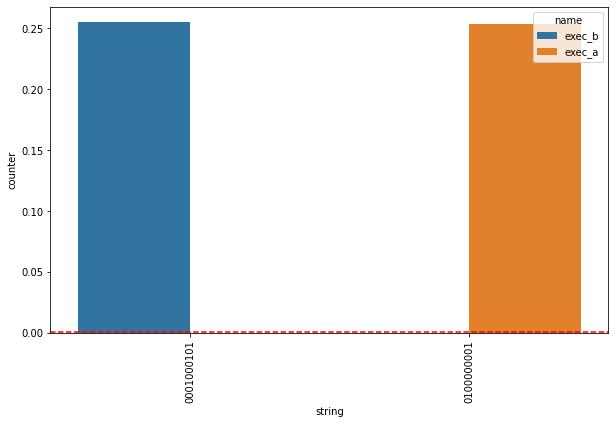

In [57]:
OneNightStandInspector(RES["res_A"], RES["res_B"], top_perc=.25)

# BUGS

## BUG: too many subscripts in einsum [LIMITATION]
https://github.com/Qiskit/qiskit-terra/issues/7700

qmt_v06 948f90de9947418289b220bd2e61caa3

In [34]:
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister
qr = QuantumRegister(11, name='qr')
cr = ClassicalRegister(11, name='cr')
qc = QuantumCircuit(qr, cr, name='qc')
subcircuit = QuantumCircuit(qr, cr, name='subcircuit')
subcircuit.x(3)
qc.append(subcircuit, qargs=qr, cargs=cr)
qc.x(3)
qc.draw(fold=-1)

┌──────────────┐     
 qr_0: ┤0             ├─────
       │              │     
 qr_1: ┤1             ├─────
       │              │     
 qr_2: ┤2             ├─────
       │              │┌───┐
 qr_3: ┤3             ├┤ X ├
       │              │└───┘
 qr_4: ┤4             ├─────
       │              │     
 qr_5: ┤5             ├─────
       │              │     
 qr_6: ┤6             ├─────
       │              │     
 qr_7: ┤7             ├─────
       │              │     
 qr_8: ┤8             ├─────
       │              │     
 qr_9: ┤9             ├─────
       │              │     
qr_10: ┤10            ├─────
       │   subcircuit │     
 cr_0: ╡0             ╞═════
       │              │     
 cr_1: ╡1             ╞═════
       │              │     
 cr_2: ╡2             ╞═════
       │              │     
 cr_3: ╡3             ╞═════
       │              │     
 cr_4: ╡4             ╞═════
       │              │     
 cr_5: ╡5             ╞═════
       │              │     
 cr_6: ╡6             ╞═════
       │              │     
 cr_7: ╡7             ╞═════
       │              │     
 cr_8: ╡8             ╞═════
       │              │     
 cr_9: ╡9             ╞═════
       │              │     
cr_10: ╡10            ╞═════
       └──────────────┘

In [37]:
import pdb
pdb.set_trace()
from qiskit import transpile
qc = transpile(qc, basis_gates=None, optimization_level=2, coupling_map=None)

--Return--
None
> /tmp/ipykernel_41006/1682671566.py(2)<module>()
      1 import pdb
----> 2 pdb.set_trace()
      3 from qiskit import transpile
      4 qc = transpile(qc, basis_gates=None, optimization_level=2, coupling_map=None)

ipdb> b /home/paltenmo/.conda/envs/ML4Quantum/lib/python3.8/site-packages/qiskit/transpiler/passes/optimization/commutation_analysis.py:77
Breakpoint 21 at /home/paltenmo/.conda/envs/ML4Quantum/lib/python3.8/site-packages/qiskit/transpiler/passes/optimization/commutation_analysis.py:77
ipdb> c
> /home/paltenmo/.conda/envs/ML4Quantum/lib/python3.8/site-packages/qiskit/transpiler/passes/optimization/commutation_analysis.py(77)run()
     75                     does_commute = False
     76                     try:
21-> 77                         does_commute = _commute(current_gate, prev_gate, self.cache)
     78                     except TranspilerError:
     79                         pass

ipdb> c
> /home/paltenmo/.conda/envs/ML4Quantum/lib/python3.8/site-p

ipdb> q


BdbQuit: 

In [16]:
# b /home/paltenmo/.conda/envs/ML4Quantum/lib/python3.8/site-packages/qiskit/transpiler/passes/optimization/commutation_analysis.py:77
# fails when (8 continue then 1 step)
# print(current_gate.op); print(prev_gate.op); end
# Instruction(name='p', num_qubits=1, num_clbits=0, params=[1.4169402094934866])
# Instruction(name='subcircuit_dg', num_qubits=11, num_clbits=11, params=[])


# b /home/paltenmo/.conda/envs/ML4Quantum/lib/python3.8/site-packages/qiskit/transpiler/passes/optimization/commutation_analysis.py:137
# genexpr # qarg1 = tuple(qarg[q] for q in node1.qargs)

# b /home/paltenmo/.conda/envs/ML4Quantum/lib/python3.8/site-packages/qiskit/transpiler/passes/optimization/commutation_analysis.py:170

# b /home/paltenmo/.conda/envs/ML4Quantum/lib/python3.8/site-packages/qiskit/quantum_info/operators/operator.py:451
# _einsum_matmul()

In [14]:
# 11 bits failing
import pdb
pdb.set_trace()
from qiskit import transpile
qc = transpile(qc, basis_gates=None, optimization_level=2, coupling_map=None)


--Return--
None
> /tmp/ipykernel_41006/2811827985.py(2)<module>()
      1 import pdb
----> 2 pdb.set_trace()
      3 from qiskit import transpile
      4 qc = transpile(qc, basis_gates=None, optimization_level=2, coupling_map=None)

ipdb> b /home/paltenmo/.conda/envs/ML4Quantum/lib/python3.8/site-packages/qiskit/transpiler/passes/optimization/commutation_analysis.py:77
Breakpoint 10 at /home/paltenmo/.conda/envs/ML4Quantum/lib/python3.8/site-packages/qiskit/transpiler/passes/optimization/commutation_analysis.py:77
ipdb> commands 10 
(com) print(current_gate.op); print(prev_gate.op);
(com) end
ipdb> c
> /home/paltenmo/.conda/envs/ML4Quantum/lib/python3.8/site-packages/qiskit/transpiler/passes/optimization/commutation_analysis.py(77)run()
     75                     does_commute = False
     76                     try:
10-> 77                         does_commute = _commute(current_gate, prev_gate, self.cache)
     78                     except TranspilerError:
     79                   

ipdb> commands 5 
(com) print(current_gate.op); print(prev_gate.op);
(com) end
ipdb> c
> /home/paltenmo/.conda/envs/ML4Quantum/lib/python3.8/site-packages/qiskit/transpiler/passes/optimization/commutation_analysis.py(77)run()
     75                     does_commute = False
     76                     try:
3--> 77                         does_commute = _commute(current_gate, prev_gate, self.cache)
     78                     except TranspilerError:
     79                         pass

ipdb> print(current_gate.op); print(prev_gate.op);
Instruction(name='p', num_qubits=1, num_clbits=0, params=[1.4169402094934866])
Instruction(name='subcircuit', num_qubits=11, num_clbits=11, params=[])
ipdb> s
--Call--
> /home/paltenmo/.conda/envs/ML4Quantum/lib/python3.8/site-packages/qiskit/transpiler/passes/optimization/commutation_analysis.py(117)_commute()
    115 
    116 
--> 117 def _commute(node1, node2, cache):
    118     if not isinstance(node1, DAGOpNode) or not isinstance(node2, DAGOpNode):

ipdb> n
> /home/paltenmo/.conda/envs/ML4Quantum/lib/python3.8/site-packages/qiskit/quantum_info/operators/operator.py(244)compose()
    242         new_shape = self._op_shape.compose(other._op_shape, qargs, front)
    243         input_dims = new_shape.dims_r()
--> 244         output_dims = new_shape.dims_l()
    245 
    246         # Full composition of operators

ipdb> n
> /home/paltenmo/.conda/envs/ML4Quantum/lib/python3.8/site-packages/qiskit/quantum_info/operators/operator.py(247)compose()
    245 
    246         # Full composition of operators
--> 247         if qargs is None:
    248             if front:
    249                 # Composition self * other

ipdb> n
> /home/paltenmo/.conda/envs/ML4Quantum/lib/python3.8/site-packages/qiskit/quantum_info/operators/operator.py(259)compose()
    257 
    258         # Compose with other on subsystem
--> 259         num_qargs_l, num_qargs_r = self._op_shape.num_qargs
    260         if front:
    261             num_indices = num_qar

ipdb> n
> /home/paltenmo/.conda/envs/ML4Quantum/lib/python3.8/site-packages/qiskit/quantum_info/operators/operator.py(276)compose()
    274         mat = np.reshape(other.data, other._op_shape.tensor_shape)
    275         indices = [num_indices - 1 - qubit for qubit in qargs]
--> 276         final_shape = [np.product(output_dims), np.product(input_dims)]
    277         data = np.reshape(
    278             Operator._einsum_matmul(tensor, mat, indices, shift, right_mul), final_shape

ipdb> n
> /home/paltenmo/.conda/envs/ML4Quantum/lib/python3.8/site-packages/qiskit/quantum_info/operators/operator.py(277)compose()
    275         indices = [num_indices - 1 - qubit for qubit in qargs]
    276         final_shape = [np.product(output_dims), np.product(input_dims)]
--> 277         data = np.reshape(
    278             Operator._einsum_matmul(tensor, mat, indices, shift, right_mul), final_shape
    279         )

ipdb> n
> /home/paltenmo/.conda/envs/ML4Quantum/lib/python3.8/site-packages

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



ipdb> tensor.shape
(2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2)
ipdb> final_shape[0]
2048
ipdb> indices
[9, 8, 7, 10, 6, 5, 4, 3, 2, 1, 0]
ipdb> qargs
(1, 2, 3, 0, 4, 5, 6, 7, 8, 9, 10)
ipdb> self._op_shape.tensor_shape
(2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2)
ipdb> right_mul.shape
*** AttributeError: 'bool' object has no attribute 'shape'
ipdb> right_mul
False
ipdb> shift
0
ipdb> mat.shape
(2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2)
ipdb> mat.ndim
22
ipdb> tensor.ndim
22
ipdb> n
ValueError: too many subscripts in einsum
> /home/paltenmo/.conda/envs/ML4Quantum/lib/python3.8/site-packages/qiskit/quantum_info/operators/operator.py(278)compose()
    276         final_shape = [np.product(output_dims), np.product(input_dims)]
    277         data = np.reshape(
--> 278             Operator._einsum_matmul(tensor, mat, indices, shift, right_mul), final_shape
    279         )
    280         ret = Operator(data, input_dims,

BdbQuit: 

In [11]:
# 10 bits WORKING

import pdb
pdb.set_trace()
from qiskit import transpile
qc = transpile(qc, basis_gates=None, optimization_level=2, coupling_map=None)


--Return--
None
> /tmp/ipykernel_41006/2811827985.py(2)<module>()
      1 import pdb
----> 2 pdb.set_trace()
      3 from qiskit import transpile
      4 qc = transpile(qc, basis_gates=None, optimization_level=2, coupling_map=None)

ipdb> b /home/paltenmo/.conda/envs/ML4Quantum/lib/python3.8/site-packages/qiskit/transpiler/passes/optimization/commutation_analysis.py:77
Breakpoint 8 at /home/paltenmo/.conda/envs/ML4Quantum/lib/python3.8/site-packages/qiskit/transpiler/passes/optimization/commutation_analysis.py:77
ipdb> commands
(com) print(current_gate.op); print(prev_gate.op);
(com) end
ipdb> c
> /home/paltenmo/.conda/envs/ML4Quantum/lib/python3.8/site-packages/qiskit/transpiler/passes/optimization/commutation_analysis.py(77)run()
     75                     does_commute = False
     76                     try:
8--> 77                         does_commute = _commute(current_gate, prev_gate, self.cache)
     78                     except TranspilerError:
     79                        

ipdb> print(current_gate.op); print(prev_gate.op);
Instruction(name='p', num_qubits=1, num_clbits=0, params=[1.4169402094934866])
Instruction(name='subcircuit', num_qubits=10, num_clbits=10, params=[])
ipdb> s
--Call--
> /home/paltenmo/.conda/envs/ML4Quantum/lib/python3.8/site-packages/qiskit/transpiler/passes/optimization/commutation_analysis.py(117)_commute()
    115 
    116 
--> 117 def _commute(node1, node2, cache):
    118     if not isinstance(node1, DAGOpNode) or not isinstance(node2, DAGOpNode):
    119         return False

ipdb> b /home/paltenmo/.conda/envs/ML4Quantum/lib/python3.8/site-packages/qiskit/transpiler/passes/optimization/commutation_analysis.py:170
Breakpoint 9 at /home/paltenmo/.conda/envs/ML4Quantum/lib/python3.8/site-packages/qiskit/transpiler/passes/optimization/commutation_analysis.py:170
ipdb> c
> /home/paltenmo/.conda/envs/ML4Quantum/lib/python3.8/site-packages/qiskit/transpiler/passes/optimization/commutation_analysis.py(170)_commute()
    168            

ipdb> n
> /home/paltenmo/.conda/envs/ML4Quantum/lib/python3.8/site-packages/qiskit/quantum_info/operators/operator.py(243)compose()
    241         # operator dimensions
    242         new_shape = self._op_shape.compose(other._op_shape, qargs, front)
--> 243         input_dims = new_shape.dims_r()
    244         output_dims = new_shape.dims_l()
    245 

ipdb> n
> /home/paltenmo/.conda/envs/ML4Quantum/lib/python3.8/site-packages/qiskit/quantum_info/operators/operator.py(244)compose()
    242         new_shape = self._op_shape.compose(other._op_shape, qargs, front)
    243         input_dims = new_shape.dims_r()
--> 244         output_dims = new_shape.dims_l()
    245 
    246         # Full composition of operators

ipdb> n
> /home/paltenmo/.conda/envs/ML4Quantum/lib/python3.8/site-packages/qiskit/quantum_info/operators/operator.py(247)compose()
    245 
    246         # Full composition of operators
--> 247         if qargs is None:
    248             if front:
    249            

ipdb> n
> /home/paltenmo/.conda/envs/ML4Quantum/lib/python3.8/site-packages/qiskit/quantum_info/operators/operator.py(275)compose()
    273         tensor = np.reshape(self.data, self._op_shape.tensor_shape)
    274         mat = np.reshape(other.data, other._op_shape.tensor_shape)
--> 275         indices = [num_indices - 1 - qubit for qubit in qargs]
    276         final_shape = [np.product(output_dims), np.product(input_dims)]
    277         data = np.reshape(

ipdb> n
> /home/paltenmo/.conda/envs/ML4Quantum/lib/python3.8/site-packages/qiskit/quantum_info/operators/operator.py(276)compose()
    274         mat = np.reshape(other.data, other._op_shape.tensor_shape)
    275         indices = [num_indices - 1 - qubit for qubit in qargs]
--> 276         final_shape = [np.product(output_dims), np.product(input_dims)]
    277         data = np.reshape(
    278             Operator._einsum_matmul(tensor, mat, indices, shift, right_mul), final_shape

ipdb> list 276
    271         # qubit 

BdbQuit: 

In [96]:
qr = QuantumRegister(1, name='qr')
cr = ClassicalRegister(1, name='cr')
qc = QuantumCircuit(qr, cr, name='qc')
qc.append(XGate(), qargs=[qr[0]], cargs=[])
qc.append(XGate(), qargs=[qrc[0]], cargs=[])
qc.append(PhaseGate(1.4169402094934866), qargs=[qr[0]], cargs=[])
qc.draw(fold=-1)

┌───┐┌───┐┌───────────┐
  qr: ┤ X ├┤ X ├┤ P(1.4169) ├
      └───┘└───┘└───────────┘
cr: 1/═══════════════════════

In [107]:
%debug

> /home/paltenmo/.conda/envs/ML4Quantum/lib/python3.8/site-packages/numpy/core/einsumfunc.py(1361)einsum()
   1359         if specified_out:
   1360             kwargs['out'] = out
-> 1361         return c_einsum(*operands, **kwargs)
   1362 
   1363     # Check the kwargs to avoid a more cryptic error later, without having to

ipdb> q


## BUG: HoareOptimization [bug if we want to allow sub-circuit optimizations]
qmt_v05 824c28fef26e41ab8ca656c1068c5799


The hoare optimization (https://arxiv.org/abs/1810.00375) removes the swap if it is swapping identical qubits, such as when it swaps two bits at the start of the circuits when they are both zeros.
Thus Hoare optimization is not suitable for optimizing a subcircuit which STARTS with a SWAP since it will be removed and the entire main cirucuit using it won't have the SWAP gate anymore.

In [125]:
import qiskit
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister
from qiskit.circuit.library.standard_gates import *

# SECTION
# NAME: CIRCUIT

qr = QuantumRegister(3, name='qr')
cr = ClassicalRegister(3, name='cr')
qc = QuantumCircuit(qr, cr, name='qc')

qc.append(U3Gate(3.1333796742925704,2.0782915724294266,3.8528667493673407), qargs=[qr[0]], cargs=[])

qc.append(SwapGate(), qargs=[qr[0], qr[1]], cargs=[])
# SECTION
# NAME: OPTIMIZATION_PASSES

from qiskit.transpiler import PassManager
from qiskit.transpiler.passes import *
passmanager = PassManager()
qc = passmanager.run(qc)

# SECTION
# NAME: OPTIMIZATION_LEVEL

from qiskit import transpile
qc = transpile(qc, basis_gates=None, optimization_level=2, coupling_map=None)

# SECTION
# NAME: MEASUREMENT

qc.measure(qr, cr)

qc.decompose().draw(fold=-1)

┌─────────────────────────┐     ┌───┐     ┌─┐   
qr_0: ┤ U(3.1334,2.0783,3.8529) ├──■──┤ X ├──■──┤M├───
      └─────────────────────────┘┌─┴─┐└─┬─┘┌─┴─┐└╥┘┌─┐
qr_1: ───────────────────────────┤ X ├──■──┤ X ├─╫─┤M├
                  ┌─┐            └───┘     └───┘ ║ └╥┘
qr_2: ────────────┤M├────────────────────────────╫──╫─
                  └╥┘                            ║  ║ 
cr: 3/═════════════╩═════════════════════════════╩══╩═
                   2                             0  1

In [126]:
# SECTION
# NAME: EXECUTION

from qiskit import Aer, transpile, execute
backend_98ae9f2e9e3f4728a9fa5a427cf0751b = Aer.get_backend('qasm_simulator')
counts_source = execute(qc, backend=backend_98ae9f2e9e3f4728a9fa5a427cf0751b, shots=489).result().get_counts(qc)
counts_source

{'010': 489}

In [127]:
# SECTION
# NAME: PROLOGUE

import qiskit
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister
from qiskit.circuit.library.standard_gates import *
from qiskit.transpiler import PassManager
from qiskit.transpiler.passes import *
# SECTION
# NAME: CIRCUIT

qr = QuantumRegister(3, name='qr')
cr = ClassicalRegister(3, name='cr')
qc = QuantumCircuit(qr, cr, name='qc')


qr_0 = QuantumRegister(3, name='qr_0')
cr_0 = ClassicalRegister(3, name='cr_0')
qc_0 = QuantumCircuit(qr_0, cr_0, name='qc_0')

qc_0.append(U3Gate(3.1333796742925704, 2.0782915724294266, 
    3.8528667493673407), qargs=[qr_0[0]], cargs=[])

qr_1 = QuantumRegister(3, name='qr_1')
cr_1 = ClassicalRegister(3, name='cr_1')
qc_1 = QuantumCircuit(qr_1, cr_1, name='qc_1')

qc_1.append(SwapGate(), qargs=[qr_1[0], qr_1[1]], cargs=[])

# OTPION 1: MEASUREMENT IN THE SUBCIRCUIT (WITH OPTIMIZATION): FAIL
# qc_1.measure(qr_1, cr_1)
# passmanager = PassManager()
# passmanager.append(HoareOptimizer(**{'size': 0}))
# qc_1 = passmanager.run(qc_1)

# OPTION 3: LOCAL OPTIMIZATION + MEASUREMENT ADD AFTER TRANSPILATION: FAIL
passmanager = PassManager()
passmanager.append(HoareOptimizer(**{'size': 0}))
qc_1 = passmanager.run(qc_1)


qc.append(qc_0, qargs=qr, cargs=cr)
qc.append(qc_1, qargs=qr, cargs=cr)

# OTPION 2: MEASUREMENT IN THE MAIN CIRCUIT AFTER GLOBAL OPTIMIZATION: WORKS
# qc.measure(qr, cr)
# passmanager = PassManager()
# passmanager.append(HoareOptimizer(**{'size': 0}))
# qc.measure(qr, cr)

qc.decompose().draw(fold=-1)

┌──────────────────────────┐
qr_0: ┤ U3(3.1334,2.0783,3.8529) ├
      └──────────────────────────┘
qr_1: ────────────────────────────
                                  
qr_2: ────────────────────────────
                                  
cr: 3/════════════════════════════

In [128]:
from qiskit import transpile
qc = transpile(qc) #, basis_gates=None, optimization_level=2, coupling_map=None)

# OPTION 3: LOCAL OPTIMIZATION + MEASUREMENT ADD AFTER TRANSPILATION: FAIL
#qc.measure(qr, cr)

from qiskit import Aer, transpile, execute
backend_98ae9f2e9e3f4728a9fa5a427cf0751b = Aer.get_backend('qasm_simulator')
counts_follow = execute(qc, backend=backend_98ae9f2e9e3f4728a9fa5a427cf0751b, shots=489).result().get_counts(qc)
counts_follow

{'000': 489}

stat: 1.0, pval: 3.069266633690399e-293
n_qubits: 3
n_shots_platform_a: 489.0
n_shots_platform_b: 489.0
Uniform threshold: 0.125


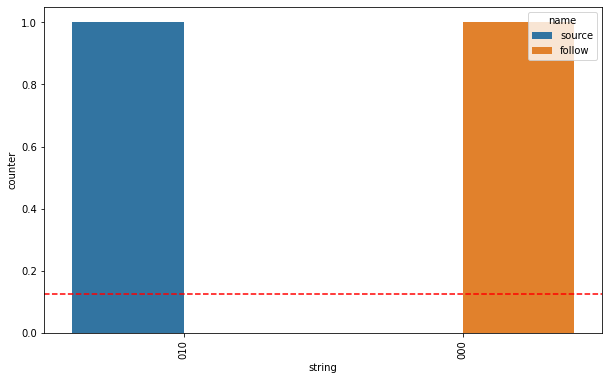

In [129]:
from inspector import OneNightStandInspector
from detectors import KS_Detector, Energy_Detector
detector = KS_Detector()
stat, pval = detector.check(counts_source, counts_follow)
print(f"stat: {stat}, pval: {pval}")
OneNightStandInspector(counts_source, counts_follow, name_a="source", name_b="follow", top_perc=1)

## BUG: GPU Nvidia template
qmt_v01 410155813be54a5287994c1d80c992dd


AER: densitymatrix_thrust.hpp
https://github.com/Qiskit/qiskit-aer/blob/53038b1962894469fcadbcd435e4f31468886f6c/src/simulators/density_matrix/densitymatrix_thrust.hpp
    
CUDA THRUST (CUDA C++ template library): thrust/system/cuda/detail/for_each.h https://github.com/NVIDIA/thrust/blob/a462ff612acfb099e78e35b57644612370969fb0/thrust/system/cuda/detail/for_each.h

OFFICIAL DOC of CUDA C++ template library: https://docs.nvidia.com/cuda/thrust/index.html




In [130]:
EXP_FOLDER = 'qmt_v01'
PROGRAM_ID = '410155813be54a5287994c1d80c992dd'

BUG_PATHS = retrieve_relevant_file_paths(
    experiment_folder=EXP_FOLDER,
    program_id=PROGRAM_ID
)
BUG_PATHS

{'source': '../data/qmt_v01/programs/source/410155813be54a5287994c1d80c992dd.py',
 'followup': '../data/qmt_v01/programs/followup/410155813be54a5287994c1d80c992dd.py',
 'metadata': '../data/qmt_v01/programs/metadata/410155813be54a5287994c1d80c992dd.json',
 'metadata_exec': '../data/qmt_v01/programs/metadata_exec/410155813be54a5287994c1d80c992dd.json'}

In [134]:
for SEED in range(1000):
    program = f"""# SECTION
# NAME: PROLOGUE

import qiskit
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister
from qiskit.circuit.library.standard_gates import *
# SECTION
# NAME: CIRCUIT

qr_qr = QuantumRegister(9, name='qr_qr')
cr_qr = ClassicalRegister(9, name='cr_qr')
qc = QuantumCircuit(qr_qr, cr_qr, name='qc')
qc.append(SXdgGate(), qargs=[qr_qr[7]], cargs=[])
qc.append(ECRGate(), qargs=[qr_qr[2], qr_qr[6]], cargs=[])
qc.append(iSwapGate(), qargs=[qr_qr[5], qr_qr[4]], cargs=[])
# SECTION
# NAME: OPTIMIZATION_PASSES

from qiskit.transpiler import PassManager
from qiskit.transpiler.passes import *
passmanager = PassManager()
qc = passmanager.run(qc)
# SECTION
# NAME: OPTIMIZATION_LEVEL

from qiskit import transpile
qc = transpile(qc, basis_gates=None, optimization_level=0, seed_transpiler={SEED})
# SECTION
# NAME: MEASUREMENT

qc.measure(qr_qr, cr_qr)
# SECTION
# NAME: EXECUTION
from qiskit import Aer, transpile, execute
backend_213141889afb4ac19d274fe469f89af0 = Aer.get_backend(
    'aer_simulator_density_matrix_gpu')
counts = execute(qc, backend=backend_213141889afb4ac19d274fe469f89af0,
    shots=3919).result().get_counts(qc)
RESULT = counts
"""
    print(f'SEED: {SEED}')
    GLOBALS = {"RESULT": 0}
    exec(program, GLOBALS)
    GLOBALS["RESULT"]

SEED: 0
SEED: 1
SEED: 2
SEED: 3
SEED: 4
SEED: 5
SEED: 6
SEED: 7
SEED: 8
SEED: 9
SEED: 10
SEED: 11
SEED: 12
SEED: 13
SEED: 14
SEED: 15
SEED: 16
SEED: 17
SEED: 18
SEED: 19
SEED: 20
SEED: 21
SEED: 22
SEED: 23
SEED: 24
SEED: 25
SEED: 26
SEED: 27
SEED: 28
SEED: 29
SEED: 30
SEED: 31
SEED: 32
SEED: 33
SEED: 34
SEED: 35
SEED: 36
SEED: 37
SEED: 38
SEED: 39
SEED: 40
SEED: 41
SEED: 42
SEED: 43
SEED: 44
SEED: 45
SEED: 46
SEED: 47
SEED: 48
SEED: 49
SEED: 50
SEED: 51
SEED: 52
SEED: 53
SEED: 54
SEED: 55
SEED: 56
SEED: 57
SEED: 58
SEED: 59
SEED: 60
SEED: 61
SEED: 62
SEED: 63
SEED: 64
SEED: 65
SEED: 66
SEED: 67
SEED: 68
SEED: 69
SEED: 70
SEED: 71
SEED: 72
SEED: 73
SEED: 74
SEED: 75
SEED: 76
SEED: 77
SEED: 78
SEED: 79
SEED: 80
SEED: 81
SEED: 82
SEED: 83
SEED: 84
SEED: 85
SEED: 86
SEED: 87
SEED: 88
SEED: 89
SEED: 90
SEED: 91
SEED: 92
SEED: 93
SEED: 94
SEED: 95
SEED: 96
SEED: 97
SEED: 98
SEED: 99
SEED: 100
SEED: 101
SEED: 102
SEED: 103
SEED: 104
SEED: 105
SEED: 106
SEED: 107
SEED: 108
SEED: 109
SEED: 110


SEED: 834
SEED: 835
SEED: 836
SEED: 837
SEED: 838
SEED: 839
SEED: 840
SEED: 841
SEED: 842
SEED: 843
SEED: 844
SEED: 845
SEED: 846
SEED: 847
SEED: 848
SEED: 849
SEED: 850
SEED: 851
SEED: 852
SEED: 853
SEED: 854
SEED: 855
SEED: 856
SEED: 857
SEED: 858
SEED: 859
SEED: 860
SEED: 861
SEED: 862
SEED: 863
SEED: 864
SEED: 865
SEED: 866
SEED: 867
SEED: 868
SEED: 869
SEED: 870
SEED: 871
SEED: 872
SEED: 873
SEED: 874
SEED: 875
SEED: 876
SEED: 877
SEED: 878
SEED: 879
SEED: 880
SEED: 881
SEED: 882
SEED: 883
SEED: 884
SEED: 885
SEED: 886
SEED: 887
SEED: 888
SEED: 889
SEED: 890
SEED: 891
SEED: 892
SEED: 893
SEED: 894
SEED: 895
SEED: 896
SEED: 897
SEED: 898
SEED: 899
SEED: 900
SEED: 901
SEED: 902
SEED: 903
SEED: 904
SEED: 905
SEED: 906
SEED: 907
SEED: 908
SEED: 909
SEED: 910
SEED: 911
SEED: 912
SEED: 913
SEED: 914
SEED: 915
SEED: 916
SEED: 917
SEED: 918
SEED: 919
SEED: 920
SEED: 921
SEED: 922
SEED: 923
SEED: 924
SEED: 925
SEED: 926
SEED: 927
SEED: 928
SEED: 929
SEED: 930
SEED: 931
SEED: 932
SEED: 933


## BUG: Removed final SWAP
qmt_v07 af46c02c1e76475f86caebb03b793f32

In [80]:
#SOURCE

# SECTION
# NAME: PROLOGUE

import qiskit
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister
from qiskit.circuit.library.standard_gates import *

# SECTION
# NAME: CIRCUIT

qr = QuantumRegister(10, name='qr')
cr = ClassicalRegister(10, name='cr')
qc = QuantumCircuit(qr, cr, name='qc')
qc.append(CUGate(1.791678723309873,3.4268190926659594,2.0348474274027337,2.3260376274746286), qargs=[qr[0], qr[5]], cargs=[])
qc.append(YGate(), qargs=[qr[8]], cargs=[])
qc.append(RZGate(5.414425485082705), qargs=[qr[1]], cargs=[])
qc.append(HGate(), qargs=[qr[2]], cargs=[])
qc.append(CSXGate(), qargs=[qr[8], qr[0]], cargs=[])
qc.append(IGate(), qargs=[qr[2]], cargs=[])
qc.append(SwapGate(), qargs=[qr[6], qr[8]], cargs=[])
qc.measure(qr, cr)

# SECTION
# NAME: OPTIMIZATION_PASSES

from qiskit.transpiler import PassManager
from qiskit.transpiler.passes import *
passmanager = PassManager()
qc = passmanager.run(qc)

# SECTION
# NAME: OPTIMIZATION_LEVEL

from qiskit import transpile
qc = transpile(qc, basis_gates=None, optimization_level=3, coupling_map=None)

# SECTION
# NAME: MEASUREMENT

qc.draw(fold=-1)

┌────┐   ┌─┐      
 qr_0: ─────────────────────■──────────────────────────────┤ Sx ├───┤M├──────
                            │                ┌─┐           └─┬──┘   └╥┘      
 qr_1: ─────────────────────┼────────────────┤M├─────────────┼───────╫───────
       ┌───┐                │                └╥┘┌───┐        │       ║ ┌─┐   
 qr_2: ┤ H ├────────────────┼─────────────────╫─┤ I ├────────┼───────╫─┤M├───
       └┬─┬┘                │                 ║ └───┘        │       ║ └╥┘   
 qr_3: ─┤M├─────────────────┼─────────────────╫──────────────┼───────╫──╫────
        └╥┘                 │                 ║  ┌─┐         │       ║  ║    
 qr_4: ──╫──────────────────┼─────────────────╫──┤M├─────────┼───────╫──╫────
         ║  ┌───────────────┴───────────────┐ ║  └╥┘         │   ┌─┐ ║  ║    
 qr_5: ──╫──┤ U(1.7917,3.4268,2.0348,2.326) ├─╫───╫──────────┼───┤M├─╫──╫────
         ║  └───────────────────────────────┘ ║   ║     ┌─┐  │   └╥┘ ║  ║    
 qr_6: ──╫────────────────────────────────────╫───╫─────┤M├──┼────╫──╫──╫────
         ║                                    ║   ║  ┌─┐└╥┘  │    ║  ║  ║    
 qr_7: ──╫────────────────────────────────────╫───╫──┤M├─╫───┼────╫──╫──╫────
         ║                ┌───┐               ║   ║  └╥┘ ║   │    ║  ║  ║ ┌─┐
 qr_8: ──╫────────────────┤ Y ├───────────────╫───╫───╫──╫───■────╫──╫──╫─┤M├
         ║                └┬─┬┘               ║   ║   ║  ║        ║  ║  ║ └╥┘
 qr_9: ──╫─────────────────┤M├────────────────╫───╫───╫──╫────────╫──╫──╫──╫─
         ║                 └╥┘                ║   ║   ║  ║        ║  ║  ║  ║ 
cr: 10/══╩══════════════════╩═════════════════╩═══╩═══╩══╩════════╩══╩══╩══╩═
         3                  9                 1   4   7  8        5  0  2  6

In [81]:
from qiskit import Aer, transpile, execute
backend_1159092e1b1b403c94c35df4e3557eaa = Aer.get_backend('qasm_simulator')
counts_source = execute(qc, backend=backend_1159092e1b1b403c94c35df4e3557eaa, shots=5542).result().get_counts(qc)

In [82]:
#FOLLOWUP
# SECTION
# NAME: PROLOGUE

import qiskit
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister
from qiskit.circuit.library.standard_gates import *
# SECTION
# NAME: CIRCUIT

qr = QuantumRegister(10, name='qr')
cr = ClassicalRegister(10, name='cr')
qc = QuantumCircuit(qr, cr, name='qc')
qc.append(CUGate(1.791678723309873, 3.4268190926659594, 2.0348474274027337, 2.3260376274746286), qargs=[qr[0], qr[5]], cargs=[])
qc.append(YGate(), qargs=[qr[8]], cargs=[])
qc.append(RZGate(5.414425485082705), qargs=[qr[1]], cargs=[])
qc.append(HGate(), qargs=[qr[2]], cargs=[])
qc.append(CSXGate(), qargs=[qr[8], qr[0]], cargs=[])
qc.append(IGate(), qargs=[qr[2]], cargs=[])
qc.append(SwapGate(), qargs=[qr[6], qr[8]], cargs=[])
qc.measure(qr, cr)
# SECTION
# NAME: OPTIMIZATION_PASSES

from qiskit.transpiler import PassManager
from qiskit.transpiler.passes import *
passmanager = PassManager()
qc = passmanager.run(qc)
# SECTION
# NAME: OPTIMIZATION_LEVEL
from qiskit import transpile
qc = transpile(qc, basis_gates=None, optimization_level=2, coupling_map=None)
# SECTION
# NAME: MEASUREMENT

qc.draw(fold=-1)

┌────┐         ┌─┐         
 qr_0: ──────────────────────────────■────────────────────────┤ Sx ├─────────┤M├─────────
       ┌────────────┐                │                        └─┬──┘┌─┐      └╥┘         
 qr_1: ┤ Rz(5.4144) ├────────────────┼──────────────────────────┼───┤M├───────╫──────────
       └───┬───┬────┘                │                ┌───┐     │   └╥┘       ║ ┌─┐      
 qr_2: ────┤ H ├─────────────────────┼────────────────┤ I ├─────┼────╫────────╫─┤M├──────
           └┬─┬┘                     │                └───┘     │    ║        ║ └╥┘      
 qr_3: ─────┤M├──────────────────────┼──────────────────────────┼────╫────────╫──╫───────
            └╥┘                      │                 ┌─┐      │    ║        ║  ║       
 qr_4: ──────╫───────────────────────┼─────────────────┤M├──────┼────╫────────╫──╫───────
             ║       ┌───────────────┴───────────────┐ └╥┘      │    ║ ┌─┐    ║  ║       
 qr_5: ──────╫───────┤ U(1.7917,3.4268,2.0348,2.326) ├──╫───────┼────╫─┤M├────╫──╫───────
             ║       └───────────────────────────────┘  ║       │    ║ └╥┘    ║  ║ ┌─┐   
 qr_6: ──────╫──────────────────────────────────────────╫───────┼────╫──╫──X──╫──╫─┤M├───
             ║                                          ║  ┌─┐  │    ║  ║  │  ║  ║ └╥┘   
 qr_7: ──────╫──────────────────────────────────────────╫──┤M├──┼────╫──╫──┼──╫──╫──╫────
             ║                     ┌───┐                ║  └╥┘  │    ║  ║  │  ║  ║  ║ ┌─┐
 qr_8: ──────╫─────────────────────┤ Y ├────────────────╫───╫───■────╫──╫──X──╫──╫──╫─┤M├
             ║                     └┬─┬┘                ║   ║        ║  ║     ║  ║  ║ └╥┘
 qr_9: ──────╫──────────────────────┤M├─────────────────╫───╫────────╫──╫─────╫──╫──╫──╫─
             ║                      └╥┘                 ║   ║        ║  ║     ║  ║  ║  ║ 
cr: 10/══════╩═══════════════════════╩══════════════════╩═══╩════════╩══╩═════╩══╩══╩══╩═
             3                       9                  4   7        1  5     0  2  6  8

In [83]:
from qiskit import Aer, transpile, execute
backend_1159092e1b1b403c94c35df4e3557eaa = Aer.get_backend('qasm_simulator')
counts_follow = execute(qc, backend=backend_1159092e1b1b403c94c35df4e3557eaa, shots=5542).result().get_counts(qc)


stat: 0.009022013713460845, pval: 0.9777867805244991
n_qubits: 10
n_shots_platform_a: 5542.0
n_shots_platform_b: 5542.0
Uniform threshold: 0.0009765625


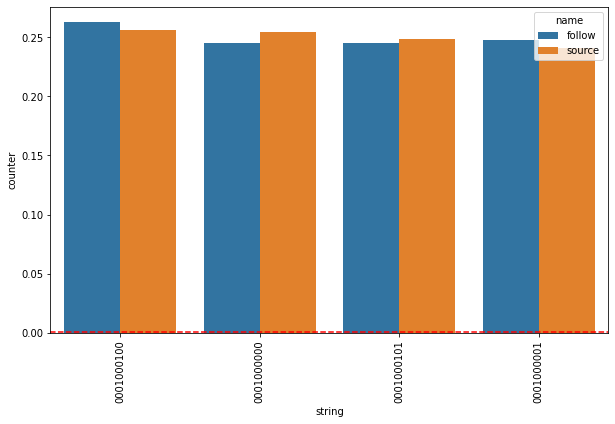

In [84]:
from inspector import OneNightStandInspector
from detectors import KS_Detector, Energy_Detector
detector = KS_Detector()
stat, pval = detector.check(counts_source, counts_follow)
print(f"stat: {stat}, pval: {pval}")
OneNightStandInspector(counts_source, counts_follow, name_a="source", name_b="follow", top_perc=1)